In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

#if gpu is avaible then our program will use it else cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### for playing with images 
#### refered from chatgpt and geek for geeks( https://www.geeksforgeeks.org/python-pillow-tutorial/?ref=lbp)

In [5]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image.to(device)

# importing content and style images
content_img = load_image("content.png")
style_img = load_image("style.png", shape=content_img.shape[-2:])


### func to show image as output

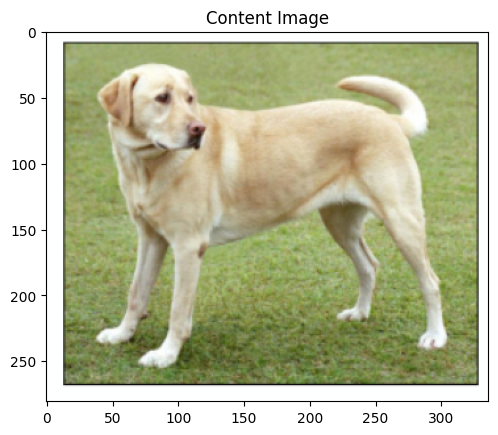

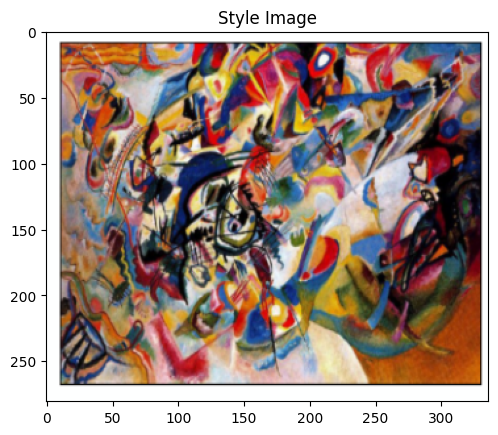

In [6]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(style_img, title='Style Image')


#### importing vgg19 pretrained model 
#### and defining the layers to use

In [8]:
vgg = models.vgg19(weights=True).features.to(device).eval()

# Freeze all VGG parameters since we're only optimizing the target image not traing the model
for param in vgg.parameters():
    param.requires_grad_(False)

# Get the style and content layers
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Calculating gram matrix for style loss
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


###  running the model

In [ ]:
# Get content and style features
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

# Calculate style gram matrices
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Initialize target image
target = content_img.clone().requires_grad_(True).to(device)

# Define style and content weights 
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e6  # beta

# Set optimizer
optimizer = optim.Adam([target], lr=0.003)

# Style transfer loop
steps = 2000 # number of iterations

for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display intermediate results
    if ii % 500 == 0:
        print('Total loss: ', total_loss.item(), "  ", "Iterations:" ,ii)
        plt.figure()
        imshow(target, title='Target Image')
